In [20]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [119]:
y = pd.read_parquet("../data/energy.parquet").asfreq("h").loc["2024":]
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7791 entries, 2024-01-01 00:00:00 to 2024-11-20 14:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    7791 non-null   float64
dtypes: float64(1)
memory usage: 121.7 KB


In [120]:
y

,load
date_time,
2024-01-01 00:00:00,42.14000
2024-01-01 01:00:00,40.17025
2024-01-01 02:00:00,38.81825
2024-01-01 03:00:00,37.84775
2024-01-01 04:00:00,37.12325
...,...
2024-11-20 10:00:00,67.48000
2024-11-20 11:00:00,68.11925
2024-11-20 12:00:00,70.35800


In [121]:
# simulate some exogenous variables
X = pd.DataFrame(index=y.index)
X["rain"] = np.random.rand(len(X)) * 10
X.head()

,rain
date_time,
2024-01-01 00:00:00,4.693650
2024-01-01 01:00:00,5.374243
2024-01-01 02:00:00,6.878425
2024-01-01 03:00:00,8.441052
2024-01-01 04:00:00,2.103900


In [122]:
def create_lagged_features_with_dummies(
    y, X, lags_target, lags_exog, exog_variables_lagged, include_dummies=True
):
    """
    Create lagged features for the target variable and exogenous variables, with optional seasonality dummies.

    Args:
        data (pd.DataFrame): Original dataset with time-series data.
        target (str): Name of the target variable column.
        exog (list): List of exogenous variable names.
        lags_target (list): List of lags for the target variable.
        lags_exog (list): List of lags for the exogenous variables.
        include_dummies (bool): Whether to add seasonality dummies (hourly, weekly, monthly).

    Returns:
        pd.DataFrame: DataFrame with lagged features and dummies.
    """
    X = X.copy()
    y = y.copy()
    y_name = y.columns[0]
    # Lagged features for exogenous variables
    suffix = "_lag"
    X_lags = X[exog_variables_lagged].shift(lags_exog, suffix=suffix)
    y_lags = y.shift(lags_target, suffix=suffix)

    Xy = pd.concat([X, X_lags, y_lags, y], axis=1).dropna()

    if include_dummies:
        # Hourly dummies
        Xy["hour_sin"] = np.sin(2 * np.pi * Xy.index.hour / 24)
        Xy["hour_cos"] = np.cos(2 * np.pi * Xy.index.hour / 24)

        # Weekly dummies
        Xy["week_sin"] = np.sin(2 * np.pi * Xy.index.weekday / 7)
        Xy["week_cos"] = np.cos(2 * np.pi * Xy.index.weekday / 7)

        # Monthly dummies
        Xy["month_sin"] = np.sin(2 * np.pi * Xy.index.month / 12)
        Xy["month_cos"] = np.cos(2 * np.pi * Xy.index.month / 12)


    X = Xy.drop(columns=y_name)
    y = Xy[y_name]
    return X, y


# Example usage
lags_target = [1, 24, 48]  # Short-term lags
lags_exog = [1, 24]
exog_variables_lagged = ["rain"]

X, y = create_lagged_features_with_dummies(
    y,
    X,
    lags_target=lags_target,
    lags_exog=lags_exog,
    exog_variables_lagged=exog_variables_lagged,
    include_dummies=True,
)
X.shape, y.shape

((7743, 12), (7743,))

In [125]:
X.head()

,rain,rain_lag_1,rain_lag_24,load_lag_1,load_lag_24,load_lag_48,hour_sin,hour_cos,week_sin,week_cos,month_sin,month_cos
date_time,,,,,,,,,,,,
2024-01-03 00:00:00,6.068980,2.983237,5.894350,52.00625,41.05725,42.14000,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025
2024-01-03 01:00:00,0.886986,6.068980,7.225041,49.06750,38.39000,40.17025,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025
2024-01-03 02:00:00,2.392995,0.886986,9.753138,46.13750,37.07800,38.81825,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025
2024-01-03 03:00:00,1.580795,2.392995,5.029172,44.33525,37.04175,37.84775,0.707107,0.707107,0.974928,-0.222521,0.5,0.866025
2024-01-03 04:00:00,1.612779,1.580795,6.372762,43.29475,37.35825,37.12325,0.866025,0.500000,0.974928,-0.222521,0.5,0.866025


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the XGBoost model with quantile loss
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
model = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=quantiles,
    n_estimators=100,
    learning_rate=0.1,
    random_state=0,
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

Text(0.5, 0, 'Feature importance')

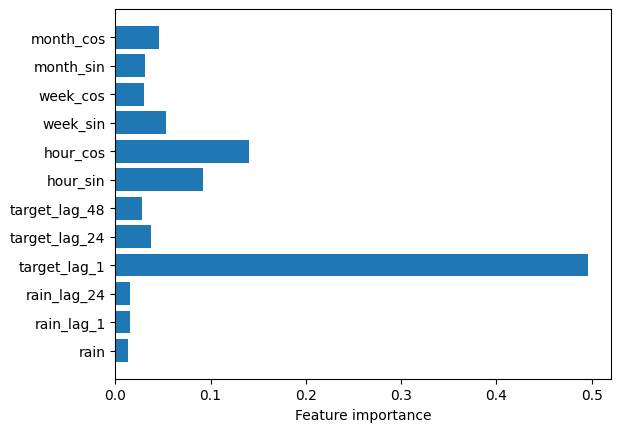

In [ ]:
# plot feature importances
import matplotlib.pyplot as plt

plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature importance")

In [54]:
model.feature_names_in_

array(['rain', 'rain_lag_1', 'rain_lag_24', 'target_lag_1',
       'target_lag_24', 'target_lag_48', 'hour_sin', 'hour_cos',
       'week_sin', 'week_cos', 'month_sin', 'month_cos'], dtype='<U13')

In [ ]:
"""Recursive forecasting with a quantile regression model."""
# Initialize an empty DataFrame to store the predictions
predictions = pd.DataFrame(index=X_test.index, columns=quantiles)
# Predict the first step
predictions.loc[X_test.index[0]] = model.predict(X_test.iloc[[0]])
# Loop through the rest of the steps
for i in range(1, len(X_test)):
    # Append the previous prediction to the features
    X_test_step = X_test.iloc[[i]]

    # use median prediction as lagged target
    X_test_step.iloc[0, X_test_step.columns.get_loc("target_lag_1")] = predictions.iloc[
        i - 1, 2
    ]
    # update the 24th lagged target
    

    # Predict the quantiles
    predictions.iloc[i] = model.predict(X_test_step)

predictions.head()

                         0.025      0.250      0.500      0.750      0.975
date_time                                                                 
2024-09-17 16:00:00  59.107197  60.020065  60.376724  60.887604  61.652946
2024-09-17 17:00:00        NaN        NaN        NaN        NaN        NaN
2024-09-17 18:00:00        NaN        NaN        NaN        NaN        NaN
2024-09-17 19:00:00        NaN        NaN        NaN        NaN        NaN
2024-09-17 20:00:00        NaN        NaN        NaN        NaN        NaN


,0.025,0.250,0.500,0.750,0.975
date_time,,,,,
2024-09-17 16:00:00,59.107197,60.020065,60.376724,60.887604,61.652946
2024-09-17 17:00:00,58.591194,59.316002,59.643978,59.843208,60.855103
2024-09-17 18:00:00,58.281971,59.339863,59.763775,60.430344,61.213295
2024-09-17 19:00:00,58.363178,59.398655,59.45472,60.11095,61.124401
2024-09-17 20:00:00,57.581112,58.317001,58.47747,59.379513,60.323555


In [63]:
# add a level to predictions, the name of the target, here "load"
predictions.columns = pd.MultiIndex.from_product([["load"], predictions.columns])
predictions.head()

load                                            
                         0.025      0.250      0.500      0.750      0.975
date_time                                                                 
2024-09-17 16:00:00  59.107197  60.020065  60.376724  60.887604  61.652946
2024-09-17 17:00:00  58.591194  59.316002  59.643978  59.843208  60.855103
2024-09-17 18:00:00  58.281971  59.339863  59.763775  60.430344  61.213295
2024-09-17 19:00:00  58.363178  59.398655   59.45472   60.11095  61.124401
2024-09-17 20:00:00  57.581112  58.317001   58.47747  59.379513  60.323555

In [ ]:
from sklearn.metrics import mean_pinball_loss


def evaluate_quantile_forecast(y_true, forecasts, quantiles):
    """
    Evaluate quantile forecasts using Pinball Loss, Interval Coverage, and Sharpness.

    Args:
        y_true (array-like): True values of the target variable.
        forecasts (dict): Forecasts for each quantile, as a dictionary {quantile: predictions}.
        quantiles (list): List of quantiles for which forecasts are made.

    Returns:
        dict: Evaluation metrics for each quantile.
    """
    results = {}
    y_true = np.array(y_true).flatten()  # Ensure y_true is a flat array
    forecasts = forecasts["load"]

    # Pinball loss for each quantile
    pinball_losses = {
        q: mean_pinball_loss(y_true, forecasts[q][: len(y_true)]) for q in quantiles
    }

    # Interval coverage and sharpness for the prediction interval (e.g., 10th to 90th quantiles)
    lower_bound = forecasts[min(quantiles)][: len(y_true)]
    upper_bound = forecasts[max(quantiles)][: len(y_true)]

    interval_coverage = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    sharpness = np.mean(upper_bound - lower_bound)

    results["pinball_losses"] = pinball_losses
    results["interval_coverage"] = interval_coverage
    results["sharpness"] = sharpness

    return results


# Evaluate hybrid forecasts
evaluation_results = evaluate_quantile_forecast(
    y_true=y_test.to_numpy().flatten(), forecasts=predictions, quantiles=quantiles
)

# Print evaluation metrics
print("\nEvaluation Results:")
print(f"Pinball Losses: {evaluation_results['pinball_losses']}")
print(f"Interval Coverage: {evaluation_results['interval_coverage']:.2f}")
print(f"Sharpness: {evaluation_results['sharpness']:.2f}")


Evaluation Results:
Pinball Losses: {0.025: 1.2928578555427077, 0.25: 1.211426234878391, 0.5: 1.298713977746622, 0.75: 1.3855880425269906, 0.975: 1.7490915287378168}
Interval Coverage: 0.35
Sharpness: 3.06


(<Figure size 1200x500 with 1 Axes>, <Axes: ylabel='load'>)

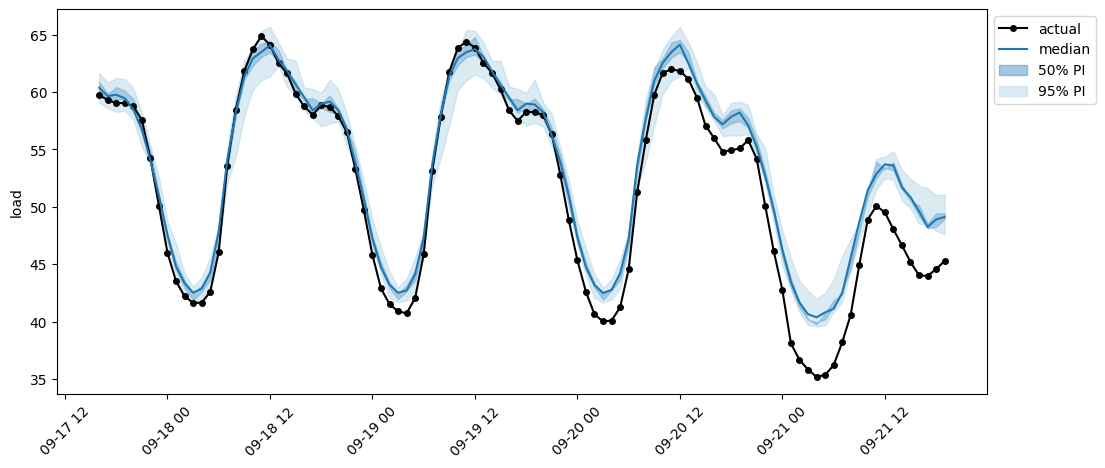

In [71]:
from probafcst.plotting import plot_quantiles
from probafcst.utils.sktime import quantiles_to_interval_df

plot_quantiles(y_test.iloc[:100], predictions.iloc[:100])